In [49]:
from mnist import MNIST
import matplotlib.pyplot as plt
import numpy as np
import markdown as mk
from __future__ import division
%matplotlib inline

### Implement layers as a python function
**1. Inner Product Forward Propagation :** <br/>
>The input unit is composed of 28 pixel by 28 pixel image in grey scale intensity(between 0 and 1). Here ｗe have 60000 input units.
Take each input then multiply them by the weight,sum all of products of all connections to the nodes.<br/>
**[60000,748] dot [748,15] ==> [60000,15]**<br/>
Here we will add bias b to get the desired function<br/>
<br/>

**2. Sigmoid Forward Propagation :**<br/>
>Sum of the Inner product For_prop is passed through the sigmoid function<br/>
<img src="figure/sigmoid.png",width=150,height=150>
>It gives the activation of each of the units in the hidden layer to make the output result become nonlinear<br/>
The gradient of the sigmoid function vanishes as we increase or decrease x<br/>
<img src="figure/figure2.png",width=250,height=250>
<br/>

**3. Rectified Forward Propagation :**<br/>
>It is an another activation function.If sum of the Inner product less than zero then output zero. If sum of the Inner product more than zero then output one
<img src="figure/relu.png",width=200,height=200>
>the gradient of the ReL function doesn't vanish as we increase x
<img src="figure/figure1.png",width=250,height=250>
<br/>

**4. Softmax Forward Propagation :** <br/>
>Softmax function can highlights the largest input and suppresses all the other smaller ones
<img src="figure/softmax.png",width=120,height=120>
>**for example : softargmax( [3,5,0] ) ≈ [0.12,0.88,0]**
 
**5. Inner Product Backward Propagation :** <br/>
Backward Pass calculate the gradient of loss，for updating parameter。This pass goes from top to bottom
>Do the partial derivative to get dEdW dEdb dEdx which means the changing value affects the total error

**6.  Sigmoid Backward Propagation :**<br/>
<img src="figure/sigmoid2.png",width=300,height=300>
<img src="figure/sigmoid1.png",width=300,height=300>
**7.  Rectified Backward Propagation :**<br/>
>if input x > 0 then it will continue propagating, else it will stop
>**dEdy[x<=0] = 0**

**8.  Softmax Backward Propagation :**<br/>
>We need to let our ouput result get closer to the training label, so we can use softmax backward propagation to find out the bias between result and label.<br/>
>>**result = [0.3, 0.2 0.5] minus label = [0, 1, 0]** <br/>
>>**==> softmax_backprop = [0.3, -0.8, 0.5] ** 
>if the bias is small ,then it means it get closer to the result.

In [50]:
def InnerProduct_ForProp(x,W,b):
    y = np.dot(x,W)+b
    return y


def InnerProduct_BackProp(dEdy,x,W,b):

    dEdb = dEdy*b    
    (n,m) = dEdb.shape
    dEdb = np.sum(dEdb) / n
    
    m = x.shape[1]
    dEdW = 1./m * np.dot(x.T,dEdy)
    
    dEdx = np.dot(dEdy,W.T)
    
    return dEdx,dEdW,dEdb

def Softmax_ForProp(x):
    # avoid overflow
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    y = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return y


def Softmax_BackProp(y,t):
    dEdx = y - t;
    return dEdx

def Sigmoid_ForProp(x):
    y = 1 / (1 + np.exp(-x))
    return y

def Sigmoid_BackProp(dEdy,x):
    dEdx = dEdy * x * (1-x)
    return dEdx

def Rectified_ForProp(x):
    y = np.maximum(x,0)
    return y

def Rectified_BackProp(dEdy,x):
    dEdy[x<=0] = 0
    dEdx = dEdy
    return dEdx

### { Load in the data } 
The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 categories (0 to 9)

In [51]:
#load MNIST data
mndata = MNIST('./data',return_type='numpy')
train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

train_labels = np.array(train_labels)
print(train_labels.shape)

(60000,)


### { Data Preprocessing }
**Image set part:**
>Separating the train_image into 7:3. Seven for training and three for validating.<br/>
>Beforeｉseparate it, i do **normalization** to make the value of data set in range (0,1) by dividing all of them in **255**

** Label set part:**
>Because each output result of images will be 10 values set, so we need to do **one hot** to make the label become ten values<br/>
**for example: label = 4 => do one hot => [0,0,0,0,1,0,0,0,0,0]**

In [52]:
#Separate train_image,train_labels into training and validating
from __future__ import division


def one_hot(x):
    #print(x)
    ofm = np.zeros(10)
    ofm[x] = 1
    #print np.array([ofm])
    return np.array([ofm])


train_images = train_images/255
test_images = test_images/255
 


training_image = train_images[:int(len(train_images)*0.7)]
validating_image = train_images[int(len(train_images)*0.7):]
testing_image = test_images[0:10000]

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

training_label =  np.empty((0,10),int)
validating_label =  np.empty((0,10),int)
testing_label =  np.empty((0,10),int)



print(train_labels.shape)
for i in range(0, int(len(train_images)*0.7)):
    training_label = np.append(training_label,one_hot(train_labels[i]),axis=0)
for i in range(42000, 60000):
    validating_label = np.append(validating_label,one_hot(train_labels[i]),axis=0)
for i in range(0, 10000):
     testing_label = np.append(testing_label,one_hot(test_labels[i]),axis=0)
print (training_label.shape)
print (validating_label.shape)
print (testing_label.shape)

(60000,)
(42000, 10)
(18000, 10)
(10000, 10)


### { Define the parameters }
**learning rate : 0.01**<br/>
**iteration : 5000**<br/>
**decay_rate : 0.8**<br/>
**Random the weights & biases at first**

In [53]:
#Parameters
eta = 0.01       #learning rate
size0 = 784     #size of layer 1 (input layer)
size1 = 15   #size of layer 2 (1st hidden layer)
size2 = 10   #size of layer 3 (output layer)
epoch = 25   #epoch for training 
iteration = 5001;
decay_rate = 0.9
params = {}
params['W1'] = np.random.randn(size0,size1)
params['b1'] = np.zeros(size1)
params['W2'] = np.random.randn(size1,size2)
params['b2'] = np.zeros(size2)

### Training Model
**1. Forward-propagation : Inner Product - Sigmoid - Inner Product - Softmax** <br/>
>*Input* : training image , weight and bias <br/>
*Output* : (42000,10) array. Included 42000 image. Each image contains 10 value which represents the confident score about digit number 0-9
<img src="figure/1-hidden.png",width=300,height=300>

**2. Backward-propagation : Softmax_back - Inner Product_back - Sigmoid_back - Inner Product_back **<br/>
>Consider w1. We want to know how much a change in w1 affects the total error<img src="figure/dedw.png",width=300,height=300>

**3. Parameter updating**
>To decrease the error, we then subtract this value from the current weight (optionally multiplied by some learning rate, eta, which we’ll set to 0.01):
>>W1 = W1 - eta * dEW1

**4. Do cross validation**
>Do the forward propagation again and get the output of "train_image prediction" and "valid_image prediction"<br/>

**5. Get Accuracy**
>Comparing the value of them with their label set which we do the one hot before to get the final accuracy
>Here i use **zip** function together two lists "image" & "label" and find their max value's index by using **argmax**<br/>
In valid image and valid label,containing 18000 elements each, the result has 18000 elements. Each element is a two-tuple (a,b)


In [9]:
from __future__ import division

W1, b1 = params['W1'], params['b1']
W2, b2 = params['W2'], params['b2']

validAccArray = np.empty((0,18000),float)
trainAccArray = np.empty((0,42000),float)

for iternum in range(iteration):
    vcorrect = []
    tcorrect = []
    
    # Forward-propagation
    a1 = InnerProduct_ForProp(training_image,W1,b1)
    z1 = Sigmoid_ForProp(a1)
    a2 = InnerProduct_ForProp(z1,W2,b2)
    out = Softmax_ForProp(a2)
    
    # Bakcward-propagation
    dEda2 =  Softmax_BackProp(out,training_label)
    dEz1,dEW2,dEb2 = InnerProduct_BackProp(dEda2,z1,W2,b2)
    dEa1 = Sigmoid_BackProp(dEz1,z1)
    dEdz0,dEW1,dEb1 = InnerProduct_BackProp(dEa1,training_image,W1,b1)
    
    # Parameters Updating (Gradient descent)
    
    W1 = W1 - eta*dEW1
    W2 = W2 - eta*dEW2
    b1 = b1 - eta*dEb1
    b2 = b2 - eta*dEb2
    
    # Do cross-validation to evaluate model
    
    z3 = InnerProduct_ForProp(training_image,W1,b1)
    a3 = Sigmoid_ForProp(z3)
    z4 = InnerProduct_ForProp(a3,W2,b2)
    trainPrediction = Softmax_ForProp(z4)
    
    z5 = InnerProduct_ForProp(validating_image,W1,b1)
    a4 = Sigmoid_ForProp(z5)
    z6 = InnerProduct_ForProp(a4,W2,b2)
    validPrediction = Softmax_ForProp(z6)
    
   
    tcorrect = [1 if a==b else 0 for (a,b) in zip(np.argmax(trainPrediction,axis=1),np.argmax(training_label,axis=1))]
    #print np.sum(tcorrect)       
    trainAccArray = np.append(trainAccArray, float(np.sum(tcorrect))/42000*100)
    #print tAccuracy
    #print  "Round : %d | Train Accuracy : %f"%(iternum, trainAccArray[iternum])
    
    vcorrect = [1 if a==b else 0 for (a,b) in zip(np.argmax(validPrediction,axis=1),np.argmax(validating_label,axis=1))]
    #print np.sum(vcorrect)   
    validAccArray = np.append(validAccArray, float(np.sum(vcorrect))/18000*100)
    #print  "Round : %d | Valid Accuracy : %f"%(iternum, validAccArray[iternum])
    #print"---------------------------------------"
    if iternum%50 ==0:
        print  "Round : %d | Train Accuracy : %f"%(iternum, trainAccArray[iternum])
        print  "Round : %d | Valid Accuracy : %f"%(iternum, validAccArray[iternum])
        print"-----------------------------------------"
    if  iternum!=0 and iternum%1000==0:
        print "decay!!..........."
        eta = eta * (decay_rate**(iternum/1000))
        #print eta  
    

Round : 0 | Train Accuracy : 10.130952
Round : 0 | Valid Accuracy : 9.744444
-----------------------------------------
Round : 50 | Train Accuracy : 46.333333
Round : 50 | Valid Accuracy : 46.366667
-----------------------------------------
Round : 100 | Train Accuracy : 59.545238
Round : 100 | Valid Accuracy : 59.088889
-----------------------------------------
Round : 150 | Train Accuracy : 59.566667
Round : 150 | Valid Accuracy : 60.144444
-----------------------------------------
Round : 200 | Train Accuracy : 65.050000
Round : 200 | Valid Accuracy : 65.794444
-----------------------------------------
Round : 250 | Train Accuracy : 69.095238
Round : 250 | Valid Accuracy : 69.811111
-----------------------------------------
Round : 300 | Train Accuracy : 72.530952
Round : 300 | Valid Accuracy : 73.194444
-----------------------------------------
Round : 350 | Train Accuracy : 75.319048
Round : 350 | Valid Accuracy : 75.822222
-----------------------------------------
Round : 400 | T

### Using test_images and test_labels to do the final test

**1. Do cross validation**
>Do the forward propagation again and get the output of "test_image prediction""<br/>

**2. Get Accuracy**
>Comparing the value of them with their label set which we do the one hot before to get the final accuracy
>Here i use **zip** function together two lists "image" & "label" and find their max value's index by using **argmax**<br/>
In test image and test label,containing 10000 elements each, the result has 10000 elements. Each element is a two-tuple (a,b)



In [54]:
#Using test_images and test_labels to do the final test
from __future__ import division

W1, b1 = params['W1'], params['b1']
W2, b2 = params['W2'], params['b2']

testAccArray = np.empty((0,10000),float)


for iternum in range(iteration):
    tcorrect = []
    # Forward-propagation
    a1 = InnerProduct_ForProp(training_image,W1,b1)
    z1 = Sigmoid_ForProp(a1)
    a2 = InnerProduct_ForProp(z1,W2,b2)
    out = Softmax_ForProp(a2)
    
    # Bakcward-propagation
    dEda2 =  Softmax_BackProp(out,training_label)
    dEz1,dEW2,dEb2 = InnerProduct_BackProp(dEda2,z1,W2,b2)
    dEa1 = Sigmoid_BackProp(dEz1,z1)
    dEdz0,dEW1,dEb1 = InnerProduct_BackProp(dEa1,training_image,W1,b1)
    
    # Parameters Updating (Gradient descent)
    
    W1 = W1 - eta*dEW1
    W2 = W2 - eta*dEW2
    b1 = b1 - eta*dEb1
    b2 = b2 - eta*dEb2
    
    # Do cross-validation to evaluate model
    
    z3 = InnerProduct_ForProp(testing_image,W1,b1)
    a3 = Sigmoid_ForProp(z3)
    z4 = InnerProduct_ForProp(a3,W2,b2)
    trainPrediction = Softmax_ForProp(z4)

    
    #print (Prediction[0])
    #print np.max(Prediction[0])
    #print np.argmax((Prediction[0]))
    #print (validating_label[0])
    #print np.argmax(validating_label[0])
    
   
    tcorrect = [1 if a==b else 0 for (a,b) in zip(np.argmax(trainPrediction,axis=1),np.argmax(testing_label,axis=1))]    
    testAccArray = np.append(testAccArray, float(np.sum(tcorrect))/10000*100)
    #print tAccuracy
    #print  "Round : %d | Test Accuracy : %f"%(iternum, testAccArray[iternum])
      
    if iternum%50 ==0:
        print  "Round : %d | Test Accuracy : %f"%(iternum, testAccArray[iternum])
    
    if  iternum!=0 and iternum%1000==0:
        print "decay!!..........."
        eta = eta * (decay_rate**(iternum/1000))

Round : 0 | Test Accuracy : 12.720000
Round : 50 | Test Accuracy : 53.700000
Round : 100 | Test Accuracy : 59.480000
Round : 150 | Test Accuracy : 64.310000
Round : 200 | Test Accuracy : 68.100000
Round : 250 | Test Accuracy : 70.910000
Round : 300 | Test Accuracy : 73.090000
Round : 350 | Test Accuracy : 75.150000
Round : 400 | Test Accuracy : 76.510000
Round : 450 | Test Accuracy : 77.680000
Round : 500 | Test Accuracy : 78.740000
Round : 550 | Test Accuracy : 79.380000
Round : 600 | Test Accuracy : 80.040000
Round : 650 | Test Accuracy : 80.730000
Round : 700 | Test Accuracy : 81.390000
Round : 750 | Test Accuracy : 81.970000
Round : 800 | Test Accuracy : 82.480000
Round : 850 | Test Accuracy : 82.930000
Round : 900 | Test Accuracy : 83.500000
Round : 950 | Test Accuracy : 83.990000
Round : 1000 | Test Accuracy : 84.250000
decay!!...........
Round : 1050 | Test Accuracy : 85.600000
Round : 1100 | Test Accuracy : 85.540000
Round : 1150 | Test Accuracy : 85.800000
Round : 1200 | Test 

### Plot iter accuracy curve and store accuracy in txt
** Print out accuracy of test, train, valid set **

In [ ]:
np.savetxt("../project1/accuracy_txt/trainacc.txt", trainAccArray , fmt="%f")
np.savetxt("../project1/accuracy_txt/validacc.txt", validAccArray , fmt="%f")
np.savetxt("../project1/accuracy_txt/testacc.txt", testAccArray , fmt="%f")

--------------------------------------------
Max Train ACC : 91.366667


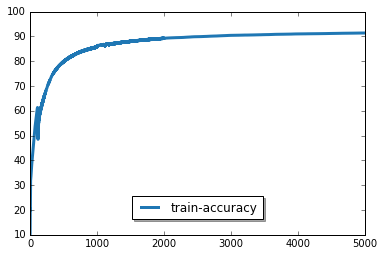

--------------------------------------------
Max Valid ACC : 90.355556


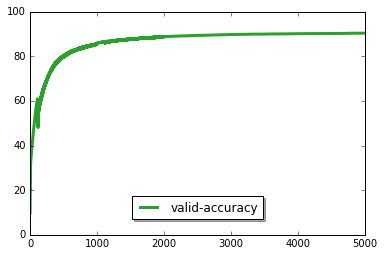

--------------------------------------------
Max Test ACC : 90.010000


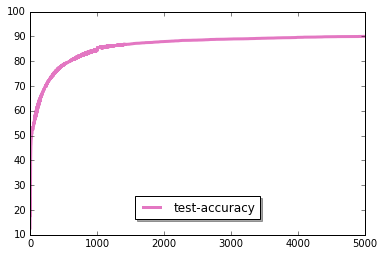

In [57]:
#Plot iter accuracy curve
#Store your every iter number and accuracy in tow numpy array "iter_log" and "accuracy_log"
#example
train_data =  np.array([data.rstrip('\n') for data in open('../project1/accuracy_txt/trainacc.txt')]).astype(np.float)
valid_data =  np.array([data.rstrip('\n') for data in open('../project1/accuracy_txt/validacc.txt')]).astype(np.float)
test_data =  np.array([data.rstrip('\n') for data in open('../project1/accuracy_txt/testacc.txt')]).astype(np.float)
print "--------------------------------------------"
print "Max Train ACC : %f"%np.max(train_data)
iter_log = np.empty((0,5001),int)
accuracy_log = np.empty((0,5001),float)
for i in range(0,5001):
    iter_log = np.append(iter_log,i)
accuracy_log = train_data

ax = plt.subplot(111)
plt.plot(iter_log, accuracy_log, label='train-accuracy', color="#1f77b4", linewidth=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.2),  shadow=True, ncol=2)
plt.show()

print "--------------------------------------------"
print "Max Valid ACC : %f"%np.max(valid_data)
iter_log = np.empty((0,5001),int)
accuracy_log = np.empty((0,5001),float)
for i in range(0,5001):
    iter_log = np.append(iter_log,i)
accuracy_log = valid_data
ax = plt.subplot(111)
plt.plot(iter_log, accuracy_log, label='valid-accuracy', color="#2ca02c", linewidth=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.2),  shadow=True, ncol=2)
plt.show()

print "--------------------------------------------"
print "Max Test ACC : %f"%np.max(test_data)
iter_log = np.empty((0,5001),int)
accuracy_log = np.empty((0,5001),float)
for i in range(0,5001):
    iter_log = np.append(iter_log,i)
accuracy_log = test_data
ax = plt.subplot(111)
plt.plot(iter_log, accuracy_log, label='test-accuracy', color="#e377c2", linewidth=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.2),  shadow=True, ncol=2)
plt.show()